# Interatomic force field (IFF) optimization for W-based metal alloys

## Raw target data processing

Author: Lukas Vlcek

Start Date: 2018-04-22

In [2]:
from datetime import datetime ; print('Last update:', datetime.now())

Last update: 2018-07-25 17:10:07.492505


## 1. Target data overview

### Bulk properties of tungsten
from _Marinica et.al_ except for B (bulk modulus) and Pc (Cauchy pressure)

T=0K?

| Property | BCC | FCC |
| :---     | :---: | :---: |
| a_0 (A) | 3.1648 | 4.054 |
| E_coh (eV/atom) | -8.9 | -8.43 |
| C11 (GPa) | 523 | - |
| C12 (GPa) | 203 | - |
| C44 (GPa) | 160 | - |
| B (GPa) | 310.4 | - |
| Pc (GPa) | 21.9 | - |

### Defect properties
(from _Marinica et.al_)

Based on 128+-1 atoms

Defect | Energy (eV)
:--- | :---:
(111) | 10.53
(110) | 10.82
(100) | 12.87
OCT | 13.11
TET | 12.27
Vacancy | 3.49

### Atomic configurations and DFT data

1. Data from Marinica
  * 20 configurations generated from liquid Fe trajectory, N=113
  * DFT Forces
  * DFT Energy
2. Data from German (local minimum energy configs.)
  * Energy, Hessians?
  * Pure phases
    * BCC (54 atoms)
    * FCC (32 atoms)
  * Vacancy
    * vacancy (53 atoms)
  * Interstitial defects 
    * 110, 111 (55 atoms)
  * Screw dislocation
    * 111_easy_core (135 atoms)?

## 2. Processing of raw data into HDF5 storage

In [24]:
%matplotlib inline
import os
import glob
import re
import numpy as np
import h5py
import pickle
import matplotlib.pyplot as plt

# source of raw data and destination for processed data
target_raw = '../data/target_raw'
target_proc = '../data/target_processed'

Some conversion constants

In [4]:
Ry2kjmol = 2625.499638/2.0      # conversion from Rydberg to kj/mol
Ry2eV = 13.6056980659           # conversion from Rydberg to eV
au2angstrom = 0.52917721092     # atomic units (length) to Angstrom

### Data from Marinica

box
coordinates
energies
forces
k,v: temperature (K)  :  4000.0
coordinates (17, 113, 3) 1.70206
forces (17, 113, 3) -8.55918


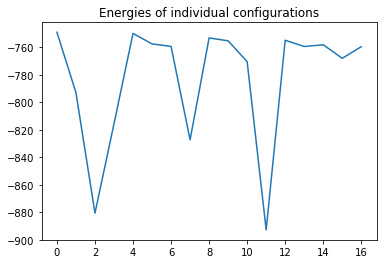

In [31]:
# source and destination directories
marini_raw = os.path.join(target_raw, 'marinica_cfg')
marini_proc = os.path.join(target_proc, 'marini')

alatt = 12.74259

# columns in a fixed format file
rcols = ( (4,14), (14,24), (24,34))  # atomic coordinates
fcols = ((34,44), (44,54), (54,64))  # atomic forces

# read target data from Marinica, extract energies, xyz, forces
enes, xyzs, frcs = [],[],[] # list of coordinates, energies, forces
for file in glob.glob(os.path.join(marini_raw, '*.ref')):
    #print(file)
    with open(file, 'r') as fi:
        ene = float(re.findall('\S+', fi.readline())[1])
        nat = int(re.findall('\S+', fi.readline())[1])
        xyz = np.zeros((nat, 3), dtype=float)
        frc = np.zeros((nat, 3), dtype=float)
        #print('number of atoms:', nat, '\nenergy:', ene)
        for i in range(nat):
            line = fi.readline()
            xyz[i] = [float(line[c[0]:c[1]]) for c in rcols]
            frc[i] = [float(line[c[0]:c[1]]) for c in fcols]
        enes.append(ene)
        xyzs.append(xyz)
        frcs.append(frc)

enes = np.array(enes)
xyzs = np.array(xyzs)
frcs = np.array(frcs)
box = np.ones_like(enes)*alatt
temps = np.ones_like(enes)*4000.0

# save trajectory in a pickle
traj = {'box':box, 'xyz':xyzs, 'energy':enes, 'forces':frcs, 'temp':temps}
with open(os.path.join(target_proc, "liq_4000k.pickle"), 'wb') as fo:
    pickle.dump(traj, fo)

# save all trajectory data in an hdf5 file
with h5py.File(os.path.join(target_proc, "marini_dft.h5"), "w") as fo:
    fo.attrs['temperature (K)'] = 4000.0
    dset_e = fo.create_dataset("energies", enes.shape, dtype='f')
    dset_e[...] = enes
    dset_r = fo.create_dataset("coordinates", xyzs.shape, dtype='f')
    dset_r[...] = xyzs
    dset_f = fo.create_dataset("forces", frcs.shape, dtype='f')
    dset_f[...] = frcs
    dset_box = fo.create_dataset("box", box.shape, dtype='f')
    dset_box[...] = box

# Check if the new file is OK
with h5py.File(os.path.join(target_proc, "marini_dft.h5"), "r") as fi:
    fi.visit(lambda x: print(x))
    [print('k,v:', k, ' : ', v) for k, v in fi.attrs.items()]
    for name in fi:
        if name != 'energies' and name != 'box':
            print(name, fi[name].shape, fi[name][0,0,0])
    plt.plot(fi['energies'])
    #plt.plot(fi['box'])
    plt.title('Energies of individual configurations')

### Data from German - zero T

In [9]:
# source and destination directories
german_raw = os.path.join(target_raw, 'dft_w')
german_proc = os.path.join(target_proc, 'german')

# directories with specific 0K data
dirs = ['bcc', 'fcc', 'vacancy', '110', '111', '111_easy_core']

# read appropriate contents - c oordinates, energies, Hessians?
sentA = "     End of BFGS Geometry Optimization\n" # sentinel 1 for file read
sentB = "End final coordinates\n"                  # sentinel 2 for file read
sent_lattic = r'(lattice parameter)'

xyz = {}
ene = {}
box = {}
for cdir in dirs:
    dname = os.path.join(german_raw, cdir)
    with open(os.path.join(dname, 'rlx.out')) as fi:
        print(os.path.join(dname, 'rlx.out'))
        for line in iter(fi.readline, sentA):
            if re.search(sent_lattic, line):
                alatt = float(re.findall('\S+', line)[-2])*au2angstrom
                break
                
        for line in iter(fi.readline, sentA):
            pass
        fi.readline()
        ene[cdir] = float(re.findall('\S+', fi.readline())[3])
        [fi.readline() for _ in range(3)]
        xyz[cdir] = np.array([list(map(float, re.findall('\S+', line)[1:4])) for line in iter(fi.readline, sentB)])
        print(xyz[cdir].shape)
        box[cdir] = alatt

# save all configurations data in an hdf5 file, labeled by type
with h5py.File(os.path.join(target_proc, "german_dft.h5"), "w") as fo:
    for cdir in dirs:
        grp = fo.create_group(cdir)
        grp.attrs['temperature (K)'] = 0.0
        dset_e = grp.create_dataset("E_conf", (1,), dtype='f')
        dset_e[...] = ene[cdir]
        dset_r = grp.create_dataset("coordinates", xyz[cdir].shape, dtype='f')
        dset_r[...] = xyz[cdir]*box[cdir]
        dset_box = grp.create_dataset("box", (1,), dtype='f')
        dset_box[...] = box[cdir]
        
# Check if the new file is OK
with h5py.File(os.path.join(target_proc, "german_dft.h5"), "r") as fi:
    fi.visit(lambda x: print(x))

../data/target_raw/dft_w/bcc/rlx.out
(54, 3)
../data/target_raw/dft_w/fcc/rlx.out
(32, 3)
../data/target_raw/dft_w/vacancy/rlx.out
(53, 3)
../data/target_raw/dft_w/110/rlx.out
(55, 3)
../data/target_raw/dft_w/111/rlx.out
(55, 3)
../data/target_raw/dft_w/111_easy_core/rlx.out
(135, 3)
110
110/E_conf
110/box
110/coordinates
111
111/E_conf
111/box
111/coordinates
111_easy_core
111_easy_core/E_conf
111_easy_core/box
111_easy_core/coordinates
bcc
bcc/E_conf
bcc/box
bcc/coordinates
fcc
fcc/E_conf
fcc/box
fcc/coordinates
vacancy
vacancy/E_conf
vacancy/box
vacancy/coordinates


** German - all 0K systems joined in a 'trajectory' **

In [32]:
# source and destination directories
german_raw = os.path.join(target_raw, 'dft_w')
german_proc = os.path.join(target_proc, 'german')

# directories with specific 0K data
#dirs = ['bcc', 'fcc', 'vacancy', '110', '111', '111_easy_core']
dirs = ['bcc', 'fcc', 'vacancy', '110', '111']

# read appropriate contents - c oordinates, energies, Hessians?
sentA = "     End of BFGS Geometry Optimization\n" # sentinel 1 for file read
sentB = "End final coordinates\n"                  # sentinel 2 for file read
sent_lattic = r'(lattice parameter)'

xyz = {}
ene = {}
box = {}
for cdir in dirs:
    dname = os.path.join(german_raw, cdir)
    with open(os.path.join(dname, 'rlx.out')) as fi:
        print(os.path.join(dname, 'rlx.out'))
        for line in iter(fi.readline, sentA):
            if re.search(sent_lattic, line):
                alatt = float(re.findall('\S+', line)[-2])*au2angstrom
                break
                
        for line in iter(fi.readline, sentA):
            pass
        fi.readline()
        ene[cdir] = float(re.findall('\S+', fi.readline())[3])
        [fi.readline() for _ in range(3)]
        xyz[cdir] = np.array([list(map(float, re.findall('\S+', line)[1:4])) for line in iter(fi.readline, sentB)])
        print(xyz[cdir].shape)
        box[cdir] = alatt
        
# Join data into pseudo-trajectories
enes = np.array([ene[cdir] for cdir in dirs])*Ry2eV
box = np.array([box[cdir] for cdir in dirs])
xyzs = np.array([xyz[cdir] for cdir in dirs])
temps = np.ones_like(enes)*0.0

print('shapes', enes.shape, box, [xyzs[i].shape for i in range(xyzs.shape[0])])
print('xyzs', type(xyzs), xyzs.shape)

# save trajectory in a pickle
traj = {'box':box, 'xyz':xyzs, 'energy':enes, 'temp':temps}
with open(os.path.join(target_proc, "structs_0k.pickle"), 'wb') as fo:
    pickle.dump(traj, fo)

## save all trajectory data in an hdf5 file
#with h5py.File(os.path.join(target_proc, "w_structures_0k.h5"), "w") as fo:
#    fo.attrs['temperature (K)'] = 0.0
#    dset_e = fo.create_dataset("energies", enes.shape, dtype='f')
#    dset_e[...] = enes
#    dset_r = fo.create_dataset("coordinates", xyzs.shape, dtype='f')
#    dset_r[...] = xyzs
#    dset_box = fo.create_dataset("box", box.shape, dtype='f')
#    dset_box[...] = box
        
# Check if the new file is OK
#with h5py.File(os.path.join(target_proc, "w_structures_0k.h5"), "r") as fi:
#    fi.visit(lambda x: print(x))
#    print(fi['coordinates'][...].shape)

../data/target_raw/dft_w/bcc/rlx.out
(54, 3)
../data/target_raw/dft_w/fcc/rlx.out
(32, 3)
../data/target_raw/dft_w/vacancy/rlx.out
(53, 3)
../data/target_raw/dft_w/110/rlx.out
(55, 3)
../data/target_raw/dft_w/111/rlx.out
(55, 3)
shapes (5,) [ 9.55471788  8.08053601  9.55471788  9.55471788  9.55471788] [(54, 3), (32, 3), (53, 3), (55, 3), (55, 3)]
xyzs <class 'numpy.ndarray'> (5,)


### Data from German - MD

Berendsent thermostat

* 300 K

../data/target_raw/dft_md
../data/target_raw/dft_md/t300K
../data/target_raw/dft_md/t300K/md.out
../data/target_raw/dft_md/t300K/md.out
(1201, 54, 3) (1201, 54, 3) (1201,) (1201,) (1201,)
E_kin
E_tot
box
coordinates
energies
forces


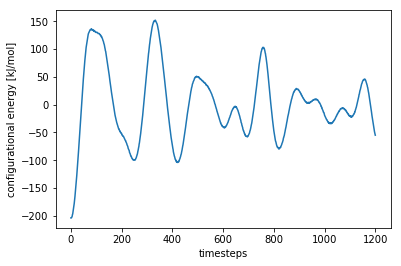

In [34]:
# source and destination directories
german_raw = os.path.join(target_raw, 'dft_md')
german_proc = os.path.join(target_proc, 'german_md')

# directories with specific temperature data
temperatures = [300.0] # K
cdirs = [ 't'+str(int(t))+'K' for t in temperatures]

# read appropriate contents - coordinates, energies, forces
sent_natoms = "number of atoms"
sent_temper = "Starting temperature"
sent_lattic = "lattice parameter"
sent_Forces = "Forces acting on atoms" # sentinel for atomic forces
sent_Coords = "ATOMIC_POSITIONS"       # sentinel for atomic coordinates
sent_Enekin = "kinetic energy"         # sentinel for kinetic energy
sent_Enetot = "Etot"            # sentinel for total energy

for cdir in cdirs:
    dname = os.path.join(german_raw, cdir)
    print(german_raw)
    print(dname)
    print(os.path.join(dname, 'md.out'))

    with open(os.path.join(dname, 'md.out')) as fi:
        print(os.path.join(dname, 'md.out'))
        
        ff = [] ; rr = [] ; E_kin = [] ; E_tot = []
        for line in iter(fi.readline, ''):
            
            if re.search(sent_lattic, line):
                alatt = float(re.findall('\S+', line)[-2])*au2angstrom
                
            if re.search(sent_natoms, line):
                natoms = int(re.findall('\S+', line)[-1])
                
            if re.search(sent_temper, line):
                temperature = float(re.findall('\S+', line)[-2])
                
            if re.search(sent_Forces, line):
                fi.readline()      
                ff.append(np.array([list(map(float, re.findall('\S+', fi.readline())[-3:])) for i in range(natoms)]))
 
            if re.search(sent_Coords, line):
                rr.append(np.array([list(map(float, re.findall('\S+', fi.readline())[-3:])) for i in range(natoms)]))
            
            if re.search(sent_Enekin, line):
                E_kin.append(float(re.findall('\S+', line)[-2]))
                
            if re.search(sent_Enetot, line):
                E_tot.append(float(re.findall('\S+', line)[-2]))
           
        ff = np.array(ff)*Ry2eV/au2angstrom # kj/mol/Angstrom
        rr = np.array(rr)*alatt
        E_tot = np.array(E_tot)*Ry2eV
        E_kin = np.array(E_kin)*Ry2eV
        box = np.ones_like(E_tot)*alatt
        
        print(ff.shape, rr.shape, E_tot.shape, E_kin.shape, box.shape)
        
    enes = E_tot - E_kin
    temps = np.ones_like(enes)*300.0
    
    # save trajectory in a pickle
    traj = {'box':box, 'xyz':rr, 'energy':enes, 'forces':ff, 'temp':temps}
    with open(os.path.join(target_proc, "bcc_300k.pickle"), 'wb') as fo:
        pickle.dump(traj, fo)

    # save all configurations data in an hdf5 file, labeled by type
    with h5py.File(os.path.join(target_proc, "md_" + cdir + ".h5"), "w") as fo:
        fo.attrs['temperature (K)'] = temperature
        dset_r = fo.create_dataset("coordinates", rr.shape, dtype='f')
        dset_r[...] = rr
        dset_box = fo.create_dataset("box", box.shape, dtype='f')
        dset_box[...] = box
        dset_f = fo.create_dataset("forces", ff.shape, dtype='f')
        dset_f[...] = ff
        dset_ek = fo.create_dataset("E_kin", E_kin.shape, dtype='f')
        dset_ek[...] = E_kin
        dset_et = fo.create_dataset("E_tot", E_tot.shape, dtype='f')
        dset_et[...] = E_tot
        ene = E_tot - E_kin
        dset_f = fo.create_dataset("energies", ene.shape, dtype='f')
        dset_f[...] = ene
        
# Check if the new file is OK
    with h5py.File(os.path.join(target_proc, "md_" + cdir + ".h5"), "r") as fi:
        fi.visit(lambda x: print(x))
    #[print('k,v:', k, ' : ', v) for k, v in fi.attrs.items()]
        #fi['E_tot'].read_direct(et)
        #fi['E_kin'].read_direct(ek)
        et = fi['E_tot'][...]
        ek = fi['E_kin'][...]
        #print('box',fi['box'][...])
        #print('coords', fi['coordinates'][...])
        #print('forces', fi['forces'][...])
        plt.plot((et - ek) - np.mean(et - ek))
        plt.xlabel('timesteps')
        plt.ylabel('configurational energy [kJ/mol]')
    #plt.title('Energies of individual configurations')

(1201, 54, 3)
Average displacement: 0.0813051914325
Force constant: 377.328297825 kJ/mol/A^2
Stress tensor C_11: 314.70013393 GPa
Average atomic displacement relative to the lattice constant: 2.56904674648 %
Maximum displacement: 0.173918
Maximum atomic displacement relative to the lattice constant: 5.49537949904 %


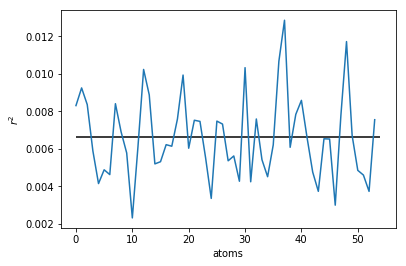

In [8]:
# Estimate the force constant and stress tensor component C_11 from the atomic distributions around COMs

cdir = 't300K'
with h5py.File(os.path.join(target_proc, "md_" + cdir + ".h5"), "r") as fi:
    rr = fi['coordinates'][...]
    print(rr.shape)
    r_var = (np.sum(np.var(rr[200:,:,:], axis=0), axis=1))
    r_var_mean = np.mean(r_var)
    print('Average displacement:', r_var_mean**0.5)#, r_var)
    plt.plot(np.arange(r_var.shape[0]), r_var)
    plt.hlines(r_var_mean, 0, r_var.shape[0])
    #plt.hist(r_var, bins=20)

    plt.xlabel('atoms')
    plt.ylabel('$r^2$')

    # Estimated harmonic force constant
    k = (8.314472*300/1000)/(r_var_mean)
    print("Force constant:", k, 'kJ/mol/A^2')

    # W atoms per 1m^2
    density = 19300 # kg/m^3
    M_W = 183.84 #g/mol atomic weight  
    N_A = (19300*1000/183.84*6.022e23)**(2/3) # number of atoms per 1m^2
    
    # Stress tensor component C_11
    a_w = 3.1648 # lattice constant
    k_atom = k*1000/6.022e23/1e-10*3.1648/1e9
    C = k_atom * N_A
    
    print("Stress tensor C_11:", C, 'GPa')
    
    print("Average atomic displacement relative to the lattice constant:", r_var_mean**0.5/a_w*100, "%")
    
    # Maximum displacement
    r_max = np.max(rr[200:,:,:] - np.mean(rr[200:,:,:], axis=0))
    print('Maximum displacement:', r_max)
    print("Maximum atomic displacement relative to the lattice constant:", r_max/a_w*100, "%")


## 3. IFF functional form

### 3.1 Finnis-Sinclair potential

Energy of an N-particle configuration

$$ E = \sum_{i=1}^N \left[ \sum_{j>i}^N V\left(r_{ij}\right) + F\left(\rho_i\right) \right] $$

Pair interaction

$$ V\left(r_{ij}\right) = \left(r_{ij}-c\right)^2\left(c_0 + c_1r_{ij} + c_2r_{ij}^2\right),\,\, r_{ij}\le c $$


Embedded function

$$ F = -A\sqrt{\rho_i} $$

Effective electron density

$$ \rho_i = \sum_{j\ne i}^N \phi\left(r_{ij}\right) $$

Cohesive potential

$$ \phi\left(r_{ij}\right) = \left(r_{ij}-d\right)^2,\,\, r_{ij}\le d $$

** Starting W parameters: ** (Finnis and Sinclair, _Phil. Mag. A_, **50(1)**, 45-66, 1984)
* Fixed
  * c = 3.25
  * d = 4.400224
* To be optimized
  * A = 1.896373
  * c0 = 47.1346499
  * c1 = -33.7665655
  * c2 = 6.2541999

## 4. Loss function

**Squared statistical distance**

  $$ s^2 = \arccos^2\left(C_B\right) $$


1. Ab initio data
  * Energies
    $$ C_B = \sum_{k=1}^{kmax} \exp\left[ -\beta\left(\Delta u_k - \Delta F\right)/2\right] $$
  * Forces
  * Hessians

2. Structural fluctuations
  * Fit Gaussian distributions described by bulk parameters
    * Mean values (A): lattice parameters (at a particular T
    * Variance (V): depends on elastic constants
    
  $$ \ln\left(C_B\right) = \frac{1}{4k_BT^2}\frac{\left(A_M - A_T\right)^2}{4\left(V_M - V_T\right)} - \frac{1}{4}\ln\frac{4 V_MV_T}{\left(V_M+V_T\right)^2} $$ 
  
  * How exactly are the different elastic constants defined?
  * Translate C11, C12, C44 to variances

## 5. Optimization

* A set of Fortran codes for parameter search on grid at:'https://github.com/vlcekl/sopt/tree/master/src/optimize/search_grid'
* A Python script for simplex search at https://github.com/vlcekl/sopt/tree/master/src/optimize/search_simplex

** Currently performing parameter grid search for FS potential ** 

**Notes**



In [8]:
import particles

ModuleNotFoundError: No module named 'particles'